In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from load_data import get_projections_spacing_radius
from ipywidgets import interact, widgets
import dill as pickle
import torch
import torch.nn.functional as F
from kornia.geometry.transform import rotate
from torch.nn.functional import interpolate
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import CubicSpline
import pytomography
import torch.nn as nn
from pytomography.utils import pad_object, unpad_object
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import psf_net
import importlib
importlib.reload(psf_net)
from psf_net import PSFNet, get_psf_net, dual_exponential, sqrt_fit
torch.set_default_device('cuda')
from fit import fit

C:\Users\lukep\AppData\Local\Temp\ipykernel_8168\1911205520.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
ds = [10,15,20,25,30,35,40,45,50,55]
paths = [f'440kev_r{d}' for d in ds]
# Spacing of the theoretical kernel
Nx = 128
dx = 0.24
x_eval = y_eval = np.arange(-(Nx-1)/2, (Nx+1)/2, 1) * dx
projectionss_data = []
projectionss_analytical = []
for path in paths:
    projections_data, dr0, distance = get_projections_spacing_radius(path)
    projectionss_data.append(projections_data)
projectionss_data = np.array(projectionss_data)

# Part 1: Fit Parameters

In [3]:
w, iso, g_params, SA, fit_func = fit(projectionss_data)

c:\Users\lukep\anaconda3\envs\pytorch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\lukep\anaconda3\envs\pytorch\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return func(*args, **kwargs)


Theory should now match data for all indices `idx`: (all projections in `projectionss_data`)

In [4]:
idx = 2
data = projectionss_data[idx]
theory = fit_func(w, iso, g_params, SA, idx)[0].cpu().detach()

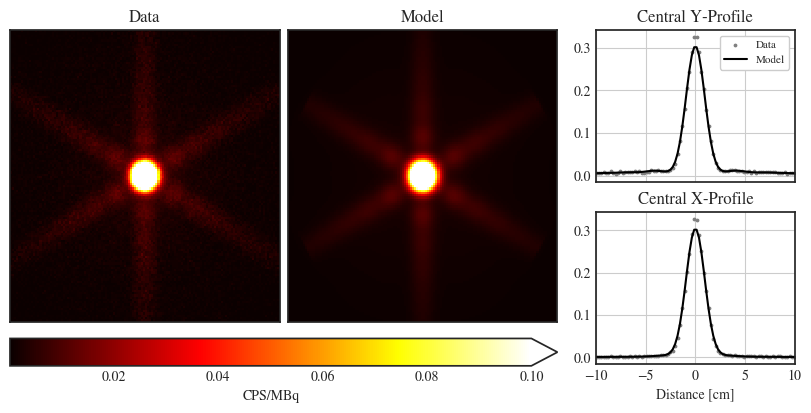

In [5]:
x = np.arange(-63.5, 64.5, 1)*dr0[0]
fig = plt.figure(constrained_layout=True, figsize=(8,4))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(2,0.85))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].pcolormesh(data.T, cmap='hot', vmax=0.1)
axes_l[0].tick_params(axis='both', which='both', length=0)
axes_l[0].set_xticklabels([])
axes_l[0].set_yticklabels([])
axes_l[0].set_title('Data')
im = axes_l[1].pcolormesh(theory.T, cmap='hot', vmax=0.1)
axes_l[1].tick_params(axis='both', which='both', length=0)
axes_l[1].set_xticklabels([])
axes_l[1].set_yticklabels([])
axes_l[1].set_title('Model')
subfig_l.colorbar(im, ax=axes_l, location='bottom', label='CPS/MBq', extend='max')

axes_r = subfig_r.subplots(nrows=2, ncols=1)
axes_r[0].scatter(x, data[64], color='grey', s=3, label='Data')
axes_r[0].plot(x, theory[64], color='k', label='Model')
axes_r[0].set_xlim(-10,10)
#axes_r[0].semilogy()
axes_r[0].set_xticklabels([])
axes_r[0].set_title('Central Y-Profile')
axes_r[0].grid()
axes_r[0].legend(facecolor='white', framealpha=1, frameon=True, loc='upper right', fontsize=8)
axes_r[1].scatter(x, data[:,64], color='grey', s=3)
axes_r[1].plot(x, theory[:,64], color='k')
axes_r[1].set_xlim(-10,10)
#axes_r[1].semilogy()
axes_r[1].set_xlabel('Distance [cm]')
axes_r[1].set_title('Central X-Profile')
axes_r[1].grid()

plt.savefig('paper_model_vs_data.png', dpi=300)

# Part 3: PSF Net

In [9]:
distances = np.array(ds)
psf_net = get_psf_net(np.array(ds), dr0[0], projectionss_data, w, iso, g_params, SA)
with open('psf_net.pkl', 'wb') as f:
    pickle.dump(psf_net, f)

In [10]:
distances = np.array(ds)
bkg_amplitude = SA[1]
bkg_sigma = SA[0]
gaus_amplitude = g_params[:,0].detach().cpu().numpy()
gaus_sigma = g_params[:,1].detach().cpu().numpy()

In [11]:
distances_theo = np.linspace(np.array(ds).min(), np.array(ds).max(), 1000)
gaus_amplitude_theo = dual_exponential(distances_theo, *psf_net.gaus_amplitude_fit)
gaus_sigma_theo = sqrt_fit(distances_theo, *psf_net.gaus_sigma_fit)
bkg_amplitude_theo = dual_exponential(distances_theo, *psf_net.bkg_amplitude_fit)
bkg_sigma_theo = sqrt_fit(distances_theo, *psf_net.bkg_sigma_fit)

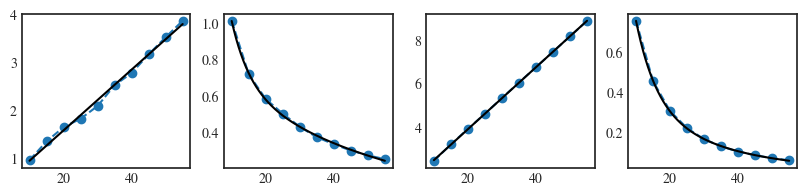

In [12]:
plt.subplots(1,4,figsize=(10,2))
plt.subplot(141)
plt.plot(distances, bkg_sigma, 'o--')
plt.plot(distances_theo, bkg_sigma_theo, color='k')
plt.subplot(142)
plt.plot(distances, bkg_amplitude, 'o--')
plt.plot(distances_theo, bkg_amplitude_theo, color='k')
plt.subplot(143)
plt.plot(distances, gaus_sigma, 'o--')
plt.plot(distances_theo, gaus_sigma_theo, color='k')
plt.subplot(144)
plt.plot(distances, gaus_amplitude, 'o--')
plt.plot(distances_theo, gaus_amplitude_theo, color='k')
plt.show()

# Timing

In [13]:
# Define distances
size = 256
pad_size = size + 2*int(np.ceil((np.sqrt(2)*size - size)/2)) 
distances_test = np.linspace(66,1,pad_size)*0 + 10
dr = 0.12
kernel_size = 128
with open('psf_net.pkl', 'rb') as f:
    psf_net = pickle.load(f)
psf_net.configure(distances_test, dr, kernel_size)

In [130]:
x = torch.zeros((1,size,size,size)).to(pytomography.device)
x[:,10:118,62:63,62:63] = 1
x = pad_object(x)
rr = psf_net(x)
rr = unpad_object(rr)

In [132]:
%%timeit
rr = psf_net(x)

188 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
t = [22, 188, ]

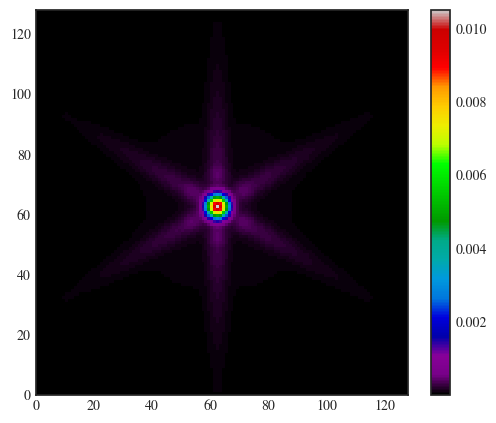

In [127]:
plt.figure(figsize=(6,5))
plt.pcolormesh(rr[0,34].cpu().detach().T, cmap='nipy_spectral')
plt.colorbar()